In [6]:
%load_ext autoreload
%autoreload 2


# sample_analysis.py

# ========================================
# SAMPLE ANALYSIS NOTEBOOK (PhaseTree Task)
# ========================================

# This notebook demonstrates key features of the Environmental Data Intelligence Platform,
# including statistical summaries, time series decomposition, anomaly detection, and more.

# ---- 1. Setup ----
import pandas as pd
from analysis_engine import WeatherAnalyzer
from visualization import VisualizationEngine
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

def show_base64_image(img_base64: str):
    html = f'<img src="data:image/png;base64,{img_base64}" />'
    return HTML(html)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# ---- 2. Load the Synthetic Dataset ----
df = pd.read_json("data/environmental_sensor_data.json")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
print("Data loaded:", df.shape)

Data loaded: (8760, 3)


In [8]:
# ---- 3. Initialize Analyzer ----
analyzer = WeatherAnalyzer(df)
viz = VisualizationEngine(analyzer)

temperature_c clean
________________________________________________________________________________
[Memory] Calling analysis_engine.cached_stl_decomposition...
cached_stl_decomposition(timestamp
2024-01-01 00:00:00    -9.63
2024-01-01 01:00:00   -11.33
2024-01-01 02:00:00    -9.96
2024-01-01 03:00:00   -10.59
2024-01-01 04:00:00    -8.73
                       ...  
2024-12-30 19:00:00     0.37
2024-12-30 20:00:00    -8.08
2024-12-30 21:00:00    -5.90
2024-12-30 22:00:00   -16.28
2024-12-30 23:00:00   -10.39
Name: temperature_c, Length: 8760, dtype: float64, 
(24,))
_________________________________________cached_stl_decomposition - 1.8s, 0.0min
________________________________________________________________________________
[Memory] Calling analysis_engine.cached_stl_decomposition...
cached_stl_decomposition(timestamp
2024-01-01 00:00:00    -9.63
2024-01-01 01:00:00   -11.33
2024-01-01 02:00:00    -9.96
2024-01-01 03:00:00   -10.59
2024-01-01 04:00:00    -8.73
                      

In [9]:
# ---- 4. Summary Statistics ----
summary = analyzer.get_data_summary()
print("Summary:")
print(summary['data_info'])
print("Basic Statistics:")
print(pd.DataFrame(summary['basic_statistics']))

Summary:
{'total_records': 8760, 'date_range': {'start': '2024-01-01T00:00:00', 'end': '2024-12-30T23:00:00'}, 'missing_data': {'temperature_c': np.int64(84), 'humidity_percent': np.int64(84), 'air_pressure_hpa': np.int64(84)}}
Basic Statistics:
       temperature_c  humidity_percent  air_pressure_hpa  temperature_c_cl  \
count    8676.000000       8676.000000       8676.000000       8662.000000   
mean       12.008401         64.802605       1013.315395         12.003626   
std        12.474843         18.471143         11.569980         12.430964   
min       -30.260000          1.100000        936.760000        -18.960000   
25%         2.400000         50.200000       1005.027500          2.400000   
50%        12.020000         65.100000       1013.335000         12.020000   
75%        21.672500         79.700000       1021.640000         21.657500   
max        61.330000        109.100000       1128.360000         44.260000   

       temperature_c_filled  humidity_percent_cl  h

In [10]:
# ---- 5. Moving Averages ----
col = "temperature_c_filled"
ma = analyzer.calculate_moving_averages(col)
ma

{'7day': {'temperature_c_filled': timestamp
  2024-01-01 00:00:00   -2.541969
  2024-01-01 01:00:00   -2.477122
  2024-01-01 02:00:00   -2.407039
  2024-01-01 03:00:00   -2.337878
  2024-01-01 04:00:00   -2.299379
                           ...   
  2024-12-30 19:00:00   -2.440272
  2024-12-30 20:00:00   -2.484707
  2024-12-30 21:00:00   -2.470853
  2024-12-30 22:00:00   -2.547956
  2024-12-30 23:00:00   -2.598873
  Name: temperature_c_filled, Length: 8760, dtype: float64},
 '30day': {'temperature_c_filled': timestamp
  2024-01-01 00:00:00   -2.029437
  2024-01-01 01:00:00   -2.040325
  2024-01-01 02:00:00   -2.059772
  2024-01-01 03:00:00   -2.068368
  2024-01-01 04:00:00   -2.069636
                           ...   
  2024-12-30 19:00:00   -3.296471
  2024-12-30 20:00:00   -3.285032
  2024-12-30 21:00:00   -3.269619
  2024-12-30 22:00:00   -3.263347
  2024-12-30 23:00:00   -3.259589
  Name: temperature_c_filled, Length: 8760, dtype: float64}}


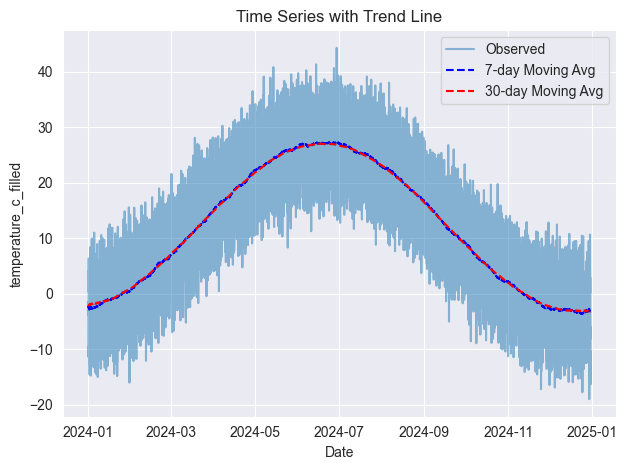

In [12]:

img = viz.timeseries("temperature_c_filled")
#display(f"{param} timeseries visualization (base64):")
show_base64_image(img)

In [13]:
# ---- 6. Trend & Seasonal Analysis ----
trends = analyzer.get_trends("temperature_c")
print("Trend Pattern Summary (temperature_c):")
for pattern in trends["patterns"]:
    print(f"Period: {pattern['period']} hours | Cycles: {pattern['cycles']}")
    print("Raw Data Stats:", pattern["raw_data"])
    print("Decomposed Stats:", pattern["decomposition"])
print("Extremes:")
print(trends["extremes"])

C:\Users\niras\PycharmProjects\phaseTreeTest\analysis_engine.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cycle"] = np.repeat(np.arange(len(df) // period_hours), period_hours)


Trend Pattern Summary (temperature_c):
Period: 24 hours | Cycles: 365
Raw Data Stats: {'mean_peak_time_day': Timedelta('0 days 11:49:14.003376727'), 'std_peak_time_day': Timedelta('0 days 01:48:17.626190702'), 'mean_valley_time_day': Timedelta('0 days 00:02:45.191140755'), 'std_valley_time_day': Timedelta('0 days 01:48:35.129358897'), 'mean_peak_time_week': Timedelta('6 days 05:22:02.788069865'), 'std_peak_time_week': Timedelta('3 days 19:30:26.926513010'), 'mean_valley_time_week': Timedelta('1 days 14:08:35.570211287'), 'std_valley_time_week': Timedelta('3 days 09:53:16.831318774'), 'mean_peak_time_year': Timedelta('55 days 23:48:00.082111713'), 'std_peak_time_year': Timedelta('251 days 06:03:42.399632022'), 'mean_valley_time_year': Timedelta('333 days 00:41:10.919890508'), 'std_valley_time_year': Timedelta('244 days 00:29:48.544900559'), 'mean_amplitude': np.float64(22.40649698925864), 'std_amplitude': np.float64(2.574052717142053)}
Decomposed Stats: {'mean_peak_time_day': Timedelta(


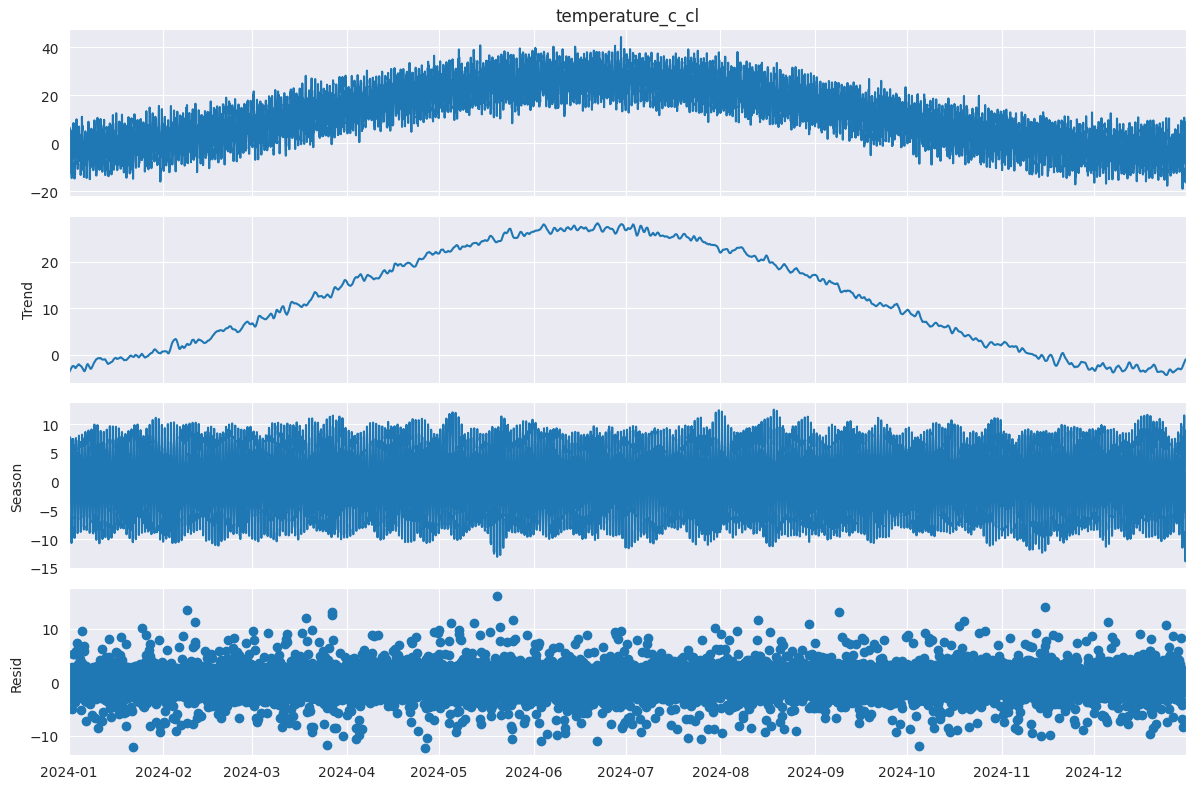

In [14]:
img = viz.decomposition("temperature_c_filled")
show_base64_image(img)

In [15]:
# ---- 7. Anomaly Detection ----
anomalies, threshold = analyzer.get_anomalies("temperature_c", method="mad")
print(f"Detected {len(anomalies)} anomalies (threshold={threshold:.2f})")

Detected 14 anomalies (threshold=6.86)


                     temperature_c      score
timestamp                                    
2024-02-07 00:00:00         -22.91   9.639266
2024-03-17 22:00:00          37.76  16.528470
2024-03-21 23:00:00          25.79   9.993701
2024-04-24 03:00:00         -14.04  14.275226
2024-05-06 02:00:00         -10.52  13.492900
2024-06-12 11:00:00          61.33  15.604000
2024-07-02 01:00:00          41.40  11.792890
2024-08-19 14:00:00           4.00  11.122501
2024-08-22 15:00:00          27.27   6.925109
2024-09-18 16:00:00          39.73  12.053599
2024-11-21 10:00:00          35.51  13.463651
2024-11-27 05:00:00         -21.41   8.342581
2024-12-28 05:00:00         -30.26  12.886120
2024-12-30 17:00:00          35.83  15.109231



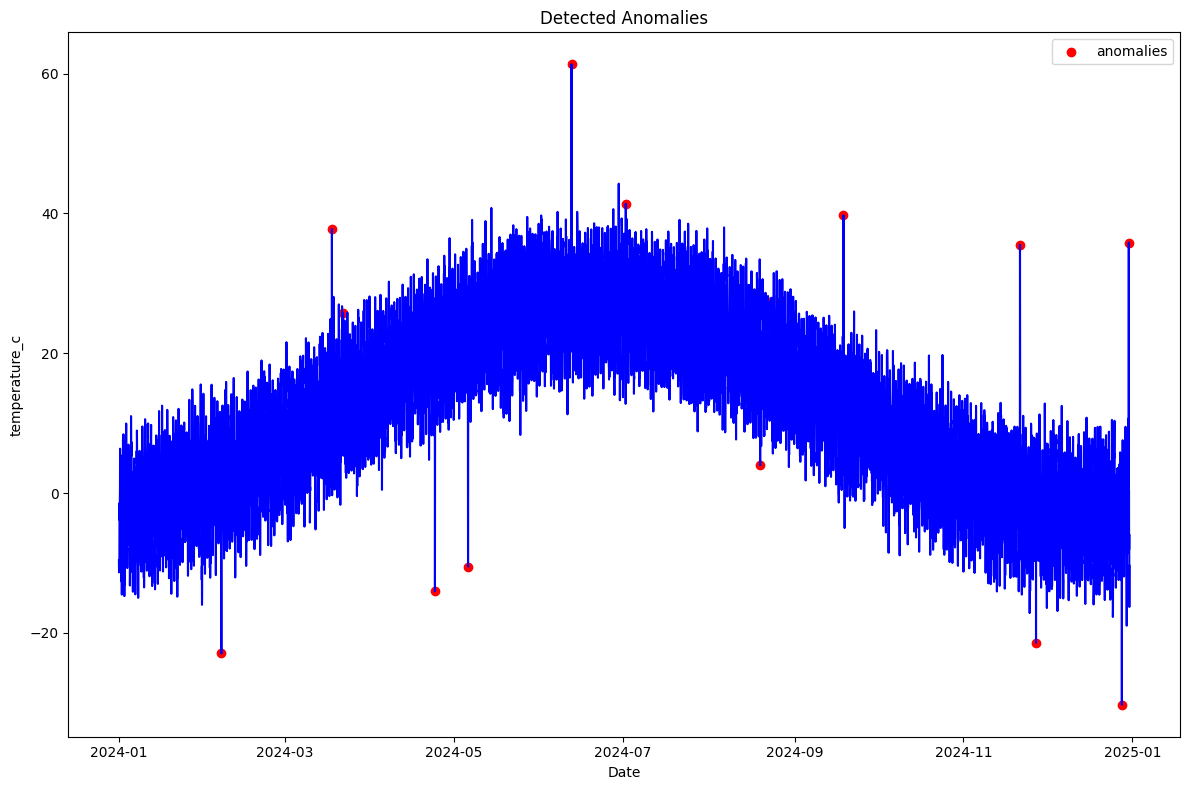

In [16]:
img = viz.anomalies("temperature_c")
show_base64_image(img)

In [32]:
# ---- 8. Correlation Analysis ----
corr = analyzer.get_correlation_matrix(method="pearson")
corr

,temperature_c_filled,humidity_percent_filled,air_pressure_hpa_filled
temperature_c_filled,1.000000,-0.584519,-0.435447
humidity_percent_filled,-0.584519,1.000000,0.442340
air_pressure_hpa_filled,-0.435447,0.442340,1.000000



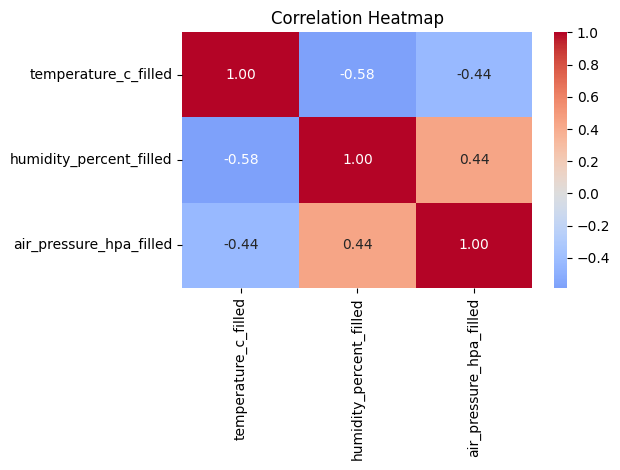

In [34]:
img = viz.correlation("pearson")
show_base64_image(img)

In [ ]:
# ---- 9. Distribution Fitting ----
fits = analyzer.fit_distributions("temperature_c_filled")
best_fit = analyzer.get_best_fit(fits)
print("Best distribution fit:", best_fit)

C:\Users\niras\PycharmProjects\phaseTreeTest\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:6918: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)



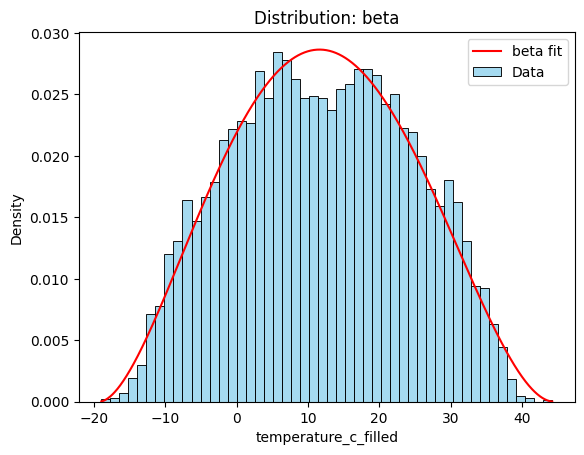

In [39]:
dists = viz.distributions("temperature_c_filled")
img = dists["distributions"][dists["best_fit"]]
show_base64_image(img)


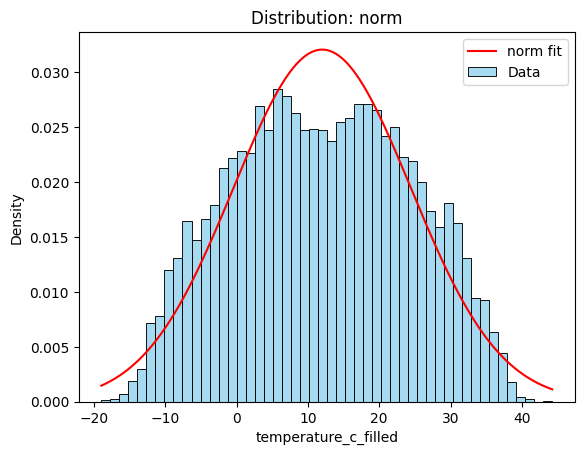

In [41]:
img = dists["distributions"]["norm"]
show_base64_image(img)

In [5]:
analyzer.fit_distributions("temperature_c_filled")  # First call → miss
analyzer.fit_distributions("temperature_c_filled")  # Second call → hit

C:\Users\niras\PycharmProjects\phaseTreeTest\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:6918: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


[('beta',
  np.float64(0.017653184597629323),
  np.float64(0.008406868960299376),
  (np.float64(2.7831699219308623),
   np.float64(2.898277706340492),
   np.float64(-19.161805927325368),
   np.float64(63.57371783332378))),
 ('gamma',
  np.float64(0.03371455733393697),
  np.float64(4.370679131691435e-09),
  (np.float64(174336.55977702342),
   np.float64(-5184.183159093905),
   np.float64(0.029805501505685974))),
 ('norm',
  np.float64(0.03387488646595588),
  np.float64(3.6141738303583545e-09),
  (np.float64(12.005523853688985), np.float64(12.444752011013152))),
 ('weibull_min',
  np.float64(0.034221421019236975),
  np.float64(2.3892922207753405e-09),
  (np.float64(2.9792790877574267),
   np.float64(-21.372815001356194),
   np.float64(37.45746392072256))),
 ('lognorm',
  np.float64(0.03538624307929694),
  np.float64(5.763495182968992e-10),
  (np.float64(0.02553695247475571),
   np.float64(-476.6611227262563),
   np.float64(488.52277213947104))),
 ('expon',
  np.float64(0.2719518838434252

In [5]:
from analysis_engine import fit_distributions_cached
from time import perf_counter as pc
fit_distributions_cached.clear()
data = analyzer.df["temperature_c_filled"].dropna().to_numpy()
t1 = pc()
fit_distributions_cached(data)  # First call → should print [Memory] Calling ...
t2 = pc()
fit_distributions_cached(data)  # Second call → should print [Memory] Loading cached ...
t3 = pc()
print(t2-t1, t3-t2)

[MemorizedFunc(func=<function fit_distributions_cached at 0x000001D2E550C5E0>, location=.joblib_cache\joblib)]: Clearing function cache identified by analysis_engine\fit_distributions_cached
C:\Users\niras\PycharmProjects\phaseTreeTest\.venv\Lib\site-packages\scipy\stats\_continuous_distns.py:6918: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


________________________________________________________________________________
[Memory] Calling analysis_engine.fit_distributions_cached...
fit_distributions_cached(array([ -9.63, ..., -10.39], shape=(8760,)))
_________________________________________fit_distributions_cached - 0.9s, 0.0min
[Memory]144.0s, 2.4min  : Loading fit_distributions_cached from .joblib_cache\joblib\analysis_engine\fit_distributions_cached\b351973fb80f8398e9213f2da93f0a02
____________________________fit_distributions_cached cache loaded - 0.0s, 0.0min
0.9957442000159062 0.01100679999217391


In [4]:
import sys
sys.stderr = sys.stdout

In [6]:
print(fit_distributions_cached.store_backend.location)
print(fit_distributions_cached.__wrapped__)

.joblib_cache\joblib
<function fit_distributions_cached at 0x000001F2FE78C220>
